<div style="background-color:#f0f8ff; color:#333333; padding:20px; border-radius:10px;">
    <h2>Project Overview: Credit Card Fraud Prediction in the United States</h2>
    <p>
        This project focuses on predicting credit card fraud in the United States, using transaction data from 2019 and 2020. 
        The primary objective is to develop a machine learning model capable of accurately identifying fraudulent credit card transactions, 
        which can help financial institutions detect fraud in real-time and prevent potential financial losses.
    </p>
    <p>
        The dataset contains various features related to both the transaction and the cardholder, such as:
    </p>
    <ul>
        <li><strong>Personal Information</strong>: Includes <code>ssn</code> (social security number), <code>cc_num</code> (credit card number), <code>first</code> (first name), 
            <code>last</code> (last name), <code>gender</code>, <code>street</code>, <code>city</code>, <code>state</code>, <code>zip</code>, 
            <code>lat</code> (latitude), <code>long</code> (longitude), <code>city_pop</code> (city population), <code>job</code>, <code>dob</code> 
            (date of birth), <code>acct_num</code> (account number), and <code>profile</code>.
        </li>
        <li><strong>Transaction Details</strong>: Includes <code>trans_num</code> (transaction number), <code>trans_date</code>, 
            <code>trans_time</code>, <code>unix_time</code>, <code>category</code> (transaction category), <code>amt</code> (transaction amount), 
            and the <code>is_fraud</code> label, which indicates whether a transaction is fraudulent (1) or non-fraudulent (0).
        </li>
        <li><strong>Merchant Information</strong>: Includes <code>merchant</code>, <code>merch_lat</code> (merchant latitude), 
            and <code>merch_long</code> (merchant longitude).
        </li>
    </ul>
    <p>
        The goal of this project is to build a predictive model using these features to classify transactions as either fraudulent or non-fraudulent. 
        By analyzing patterns in legitimate and fraudulent transactions, we aim to identify key indicators of fraud, such as unusual spending behavior, 
        geographic inconsistencies, or suspicious merchant locations.
    </p>
    <p>
        This project will explore various machine learning algorithms, comparing their performance to determine the most effective approach for detecting credit card fraud.
    </p>
</div>


In [ ]:
!pip install dask

In [1]:
# import required modules
import pandas as pd
import numpy as np
from dask import dataframe as dd
from datetime import datetime
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2

# Ignore warnings
warnings.filterwarnings('ignore')

#### <font color='Indigo'>load data and check size and fraud distribution 

In [3]:
dask_df = dd.read_csv(r'C:\Course\Repo\Files\Fraud detection\credit_card_fraud.csv')

#####  <font color='blue'> summary the total number of records and the date range of transactions

In [5]:
# Ensure 'trans_date' is in datetime format

dask_df['trans_date'] = dd.to_datetime(dask_df['trans_date'], errors='coerce')

# Compute min and max dates
min_date, max_date = dask_df['trans_date'].min().compute(), dask_df['trans_date'].max().compute()

# Compute total number of rows
total_rows = len(dask_df)

# Print the results
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")
print(f"Total Rows: {total_rows}")

Min Date: 2019-01-01 00:00:00
Max Date: 2020-12-31 00:00:00
Total Rows: 34636378


#####  <font color='blue'> total number and percentage Non-Fraud/Fraud per year and months

In [7]:
# Extract year and month from trans_date and create separate columns for them
dask_df_tmp = dask_df.copy()
dask_df_tmp['trans_year'] = dask_df_tmp['trans_date'].dt.year
dask_df_tmp['trans_month'] = dask_df_tmp['trans_date'].dt.month

# Perform groupby operation and aggregate counts for all years and months
monthly_fraud_counts = dask_df_tmp.groupby(['trans_year', 'trans_month', 'is_fraud']).size().to_frame(name='count')

# Compute the result (convert Dask to Pandas)
result = monthly_fraud_counts.compute().unstack(fill_value=0)

# Rename fraud categories for better readability
result.columns = ['Non-Fraud', 'Fraud']

# Calculate total transactions per month
result['Total'] = result['Non-Fraud'] + result['Fraud']

# Calculate the percentage of fraud per month
result['Fraud Percentage'] = (result['Fraud'] / result['Total']) * 100

# Rename the index to 'Year' and 'Month' for better clarity
result.index.names = ['Year', 'Month']

# Print the final output
print(result)


            Non-Fraud  Fraud    Total  Fraud Percentage
Year Month                                             
2019 1         961918   8248   970166          0.850164
     2         887654   7207   894861          0.805376
     3        1353168   8086  1361254          0.594011
     4        1242999   7773  1250772          0.621456
     5        1391384   8325  1399709          0.594766
     6        1630428   8196  1638624          0.500176
     7        1594009   7852  1601861          0.490180
     8        1663513   8296  1671809          0.496229
     9        1283762   8311  1292073          0.643230
     10       1283721   8091  1291812          0.626330
     11       1356713   7943  1364656          0.582051
     12       2598486   7873  2606359          0.302069
2020 1         974714   8031   982745          0.817201
     2         948504   7512   956016          0.785761
     3        1297904   7974  1305878          0.610624
     4        1250512   7743  1258255          0

<Figure size 1200x600 with 0 Axes>

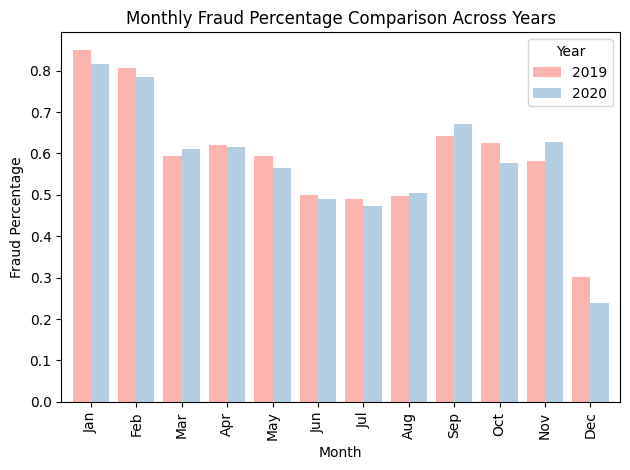

In [10]:
# Reshape the data to have 'Month' as x-axis and 'Year' as columns for the Fraud Percentage
plot_data = result.pivot_table(index='Month', columns='Year', values='Fraud Percentage')

# Define custom colors
custom_colors = sns.color_palette("Pastel1", len(plot_data.columns))

# Plotting as bar plot with custom colors
plt.figure(figsize=(12, 6))
plot_data.plot(kind='bar', width=0.8, color=custom_colors)

# Customize plot
plt.title('Monthly Fraud Percentage Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Fraud Percentage')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

<div style="background-color:#f0f8ff; color:#333333; padding:10px; border-radius:5px;">
    <p><strong>Analysis reveals that the Higher fraud rates in early months:</strong> Fraud rates peak in <strong>January and February</strong>, gradually decreasing towards mid-year, with the lowest fraud percentage in <strong>December</strong>. 
            This could be due to seasonal factors such as increased security measures during the holiday season. The fraud distribution pattern remains consistent when comparing the years 2019 and 2020. Given that each month contains approximately one million transactions, I have decided to take a representative sample of 300,000 transactions from 2020 for further analysis.</strong></p> 
</div>

#### <font color='Indigo'> get sample of data

In [16]:
# Filter rows for the year 2020
df_2020 = dask_df[dask_df['trans_date'].dt.year == 2020]

# Compute the result to get the actual dataframe
df_2020 = df_2020.compute()


In [18]:
# Save the result to a CSV file
df_2020.to_csv(r'C:\Course\Repo\Files\Fraud detection\credit_card_fraud_2020.csv', index=False)

In [19]:
# Get 300000 random rows
fraud_2020_sample = df_2020.sample(n=300000)
# Drop the Unnamed: 0 column
fraud_2020_sample = fraud_2020_sample.drop('Unnamed: 0', axis=1)

# Save the result to a CSV file
fraud_2020_sample.to_csv(r'C:\Course\Repo\Files\Fraud detection\credit_card_fraud_2020_sample.csv', index=False)

In [20]:
fraud_2020_sample = pd.read_csv(r'C:\Course\Repo\Files\Fraud detection\credit_card_fraud_2020_sample.csv')

In [22]:
df = fraud_2020_sample.copy()

#### <font color='Indigo'>Check if the distribution of fraud in the sample is similar to the distribution in the general data

In [22]:
# Perform groupby operation and aggregate counts for all years and months
df_tmp = df.copy()
df_tmp['trans_date'] =  pd.to_datetime(df['trans_date'], errors='coerce')
df_tmp['trans_year'] = df_tmp['trans_date'].dt.year
df_tmp['trans_month'] = df_tmp['trans_date'].dt.month
monthly_fraud_counts_sample = df_tmp.groupby(['trans_month', 'is_fraud']).size().to_frame(name='count')

# Compute the result (convert Dask to Pandas)
result_sample = monthly_fraud_counts_sample.unstack(fill_value=0)

# Rename fraud categories for better readability
result_sample.columns = ['Non-Fraud', 'Fraud']

# Calculate total transactions per month
result_sample['Total'] = result_sample['Non-Fraud'] + result_sample['Fraud']

# Calculate the percentage of fraud per month
result_sample['Fraud Percentage'] = (result_sample['Fraud'] / result_sample['Total']) * 100

# Rename the index to 'Year' and 'Month' for better clarity
result_sample.index.names = ['Month']

# Print the final output
print(result_sample)

       Non-Fraud  Fraud  Total  Fraud Percentage
Month                                           
1          16809    135  16944          0.796742
2          16439    105  16544          0.634671
3          22537    141  22678          0.621748
4          21603    131  21734          0.602742
5          24668    140  24808          0.564334
6          27100    138  27238          0.506645
7          28365    148  28513          0.519061
8          28769    143  28912          0.494604
9          21676    151  21827          0.691804
10         22951    132  23083          0.571849
11         22605    144  22749          0.632995
12         44848    122  44970          0.271292


#####  <font color='blue'> Comparison of Fraud Percentage Between Sample and Full Dataset (2020)

<Figure size 1200x600 with 0 Axes>

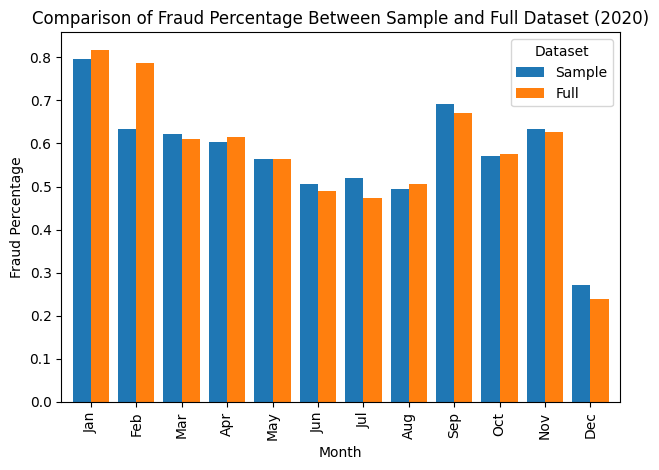

In [24]:
# Extract the fraud percentages for both datasets
fraud_percentage_sample = result_sample['Fraud Percentage']
fraud_percentage_full = result['Fraud Percentage'].loc[2020]

# Create a DataFrame to hold both fraud percentages
comparison_df = pd.DataFrame({
    'Month': fraud_percentage_sample.index,
    'Sample': fraud_percentage_sample.values,
    'Full': fraud_percentage_full.values
})

# Plot the comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(x='Month', kind='bar', width=0.8)

# Customize plot
plt.title('Comparison of Fraud Percentage Between Sample and Full Dataset (2020)')
plt.xlabel('Month')
plt.ylabel('Fraud Percentage')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Dataset', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# Calculate total chi-square statistic
chi2_total = 0
for i in range(1, 13):
    # Real fraud rate for month i
    rate = result.loc[(2020, i)]['Fraud'] / result.loc[(2020, 4)]['Total']

    # Expected counts for sample
    expected_fraud = rate * result_sample.loc[i]['Total']
    expected_nonfraud = result_sample.loc[i]['Total'] - expected_fraud
    
    # Observed counts
    observed_fraud = result_sample.loc[i]['Fraud']
    observed_nonfraud = result_sample.loc[i]['Total'] - observed_fraud
    
    # Chi-square contribution for this month
    chi2_i = ((observed_fraud - expected_fraud)**2 / expected_fraud + 
              (observed_nonfraud - expected_nonfraud)**2 / expected_nonfraud)
    chi2_total += chi2_i

# Degrees of freedom
dof = 12

# P-value
p_value = chi2.sf(chi2_total, dof)

print(f"Total chi-square statistic: {chi2_total:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

Total chi-square statistic: 76.94
Degrees of freedom: 12
P-value: 1.5770527264062658e-11


<div style="background-color:#f8f9fa; color:#333; padding:20px; border-radius:10px;">
    <h2>Comparison of Fraud Percentage Between Sample and Full Dataset (2020)</h2>
    <p>
        The bar chart above compares the percentage of fraudulent transactions between the full dataset and a sampled subset of transactions for the year 2020. 
        This comparison helps assess whether the sample accurately represents the overall fraud distribution throughout the year.
    </p>
    <ul>
        <li><strong>Fraud trends remain consistent:</strong> The sampled dataset closely follows the fraud distribution of the full dataset across all months, indicating that the sampling process did not introduce significant bias.</li>
        <li><strong>Sampling preserves data characteristics:</strong> Since the fraud percentages align well between the sample and full dataset, the sample can be considered reliable for further modeling and analysis.</li>
    </ul>
    <p>
        Ensuring that the sample distribution closely mirrors the full dataset is crucial for training a machine learning model that generalizes well to real-world data. 
        This validation step confirms that insights and model performance on the sample will likely be representative of the full dataset.
    </p>
</div>

#### <font color='Indigo'>Dataset Overview

In [34]:
df.head(5)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
21969,494-46-5528,4710716733274,Ryan,Anderson,M,202 Lee Row,Denver,CO,80228,39.6888,...,f122397b4bc6ce68bb77f4e208ccd0e6,2020-12-28,16:20:36,1609152636,travel,126.76,0,"fraud_Douglas, DuBuque and McKenzie",40.439375,-104.188791
190546,078-97-3840,4971376230938780,Brenda,Leon,F,559 Guzman Field,Albuquerque,NM,87120,35.1421,...,d1a1bc9c896ce963b7fbb495f6de7e8b,2020-09-18,18:11:29,1600432889,kids_pets,63.60,0,fraud_Brown Inc,34.524567,-106.281965
7809,182-89-4325,3504957526435280,Rose,Harris,F,1480 Daniel Mission,Chula Vista,CA,91910,32.6371,...,aac2ecd28cd63b080d741f45df457461,2020-08-30,16:23:43,1598784823,kids_pets,30.85,0,fraud_Beer-Jast,32.153218,-117.457682
180942,751-15-1762,180076273996654,Donald,Martin,M,2180 Nelson Well,Swansea,SC,29160,33.7339,...,2a44b1b4c56ca4aa168c093d57439201,2020-05-28,19:23:18,1590673998,health_fitness,141.21,0,fraud_Cormier LLC,33.229836,-80.181483
131024,496-04-4880,4474884213722,Sara,Moore,F,7434 Joshua Crossroad Suite 925,Pass Christian,MS,39571,30.3989,...,0e77c4aecbd47751743e4b70c5e2fb9d,2020-06-08,17:35:17,1591617917,health_fitness,20.04,0,fraud_Reilly and Sons,30.106802,-88.477171


In [36]:
df.shape

(300000, 26)

#### <font color='Indigo'> Data types inspection

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ssn         300000 non-null  object 
 1   cc_num      300000 non-null  int64  
 2   first       300000 non-null  object 
 3   last        300000 non-null  object 
 4   gender      300000 non-null  object 
 5   street      300000 non-null  object 
 6   city        300000 non-null  object 
 7   state       300000 non-null  object 
 8   zip         300000 non-null  int64  
 9   lat         300000 non-null  float64
 10  long        300000 non-null  float64
 11  city_pop    300000 non-null  int64  
 12  job         300000 non-null  object 
 13  dob         300000 non-null  object 
 14  acct_num    300000 non-null  int64  
 15  profile     300000 non-null  object 
 16  trans_num   300000 non-null  object 
 17  trans_date  300000 non-null  object 
 18  trans_time  300000 non-null  object 
 19  un

#### <font color='Indigo'>Statistics summary for numerical features

In [42]:
desc = pd.DataFrame(index = list(df))
desc['type'] = df.dtypes
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] /len(df) * 100
desc['null'] = df.isnull().sum()
desc['%null'] = desc['null'] / len(df) * 100
desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='pink')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
cc_num,int64,300000,17594,5.864667,0,0.000000,371458202954693376.000000,1236840715694178048.000000,60400026104.000000,38461082468737.000000,3506370325866606.000000,4589016492815037.000000,4999688876050253824.000000
zip,int64,300000,9573,3.191000,0,0.000000,51157.361887,29694.286559,1002.000000,27603.000000,48126.000000,78254.000000,99929.000000
city_pop,int64,300000,5879,1.959667,0,0.000000,295874.348973,569431.086757,44.000000,17700.000000,61361.000000,236660.000000,2906700.000000
acct_num,int64,300000,17594,5.864667,0,0.000000,496782040368.448853,289258228133.220947,18374117.000000,245271448578.000000,494656732402.000000,749263744403.000000,999958349264.000000
unix_time,int64,300000,296926,98.975333,0,0.000000,1595291882.507343,9060444.565526,1577817849.000000,1587894719.000000,1595432830.000000,1603374571.250000,1609439399.000000
is_fraud,int64,300000,2,0.000667,0,0.000000,0.005433,0.073511,0.000000,0.000000,0.000000,0.000000,1.000000
lat,float64,300000,9265,3.088333,0,0.000000,37.579210,5.177795,19.589300,33.899400,38.585500,41.229200,66.693300
long,float64,300000,9441,3.147000,0,0.000000,-91.975833,16.484961,-163.118900,-98.600600,-87.117200,-79.966700,-67.407300
amt,float64,300000,30468,10.156000,0,0.000000,65.890231,181.704306,1.000000,8.260000,33.270000,76.630000,21209.590000
merch_lat,float64,300000,297305,99.101667,0,0.000000,37.579625,5.211087,18.726265,33.871486,38.453122,41.309143,67.684577


#### <font color='Indigo'>Nulls inspection

In [45]:
pd.DataFrame({'count': df.shape[0], 
              'nulls': df.isnull().sum(), 
              'nulls%': df.isnull().mean() * 100, 
              'cardinality': df.nunique(),
             }).T

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
count,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,...,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
nulls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nulls%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cardinality,17594.0,17594.0,686.0,1000.0,2.0,17594.0,4913.0,51.0,9573.0,9265.0,...,300000.0,366.0,58324.0,296926.0,14.0,30468.0,2.0,636.0,297305.0,298816.0


#### <font color='Indigo'>Duplicates Inspection

In [48]:
df[df.duplicated() == True]

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long


#### <font color='Indigo'> Check object columns

In [51]:
# Get a list of categorical columns in the dataframe
categorical_columns = df.select_dtypes(include=['object']).columns

# Check the unique values and their counts for each categorical column
for col in categorical_columns:
    print(f"Column: {col}")
    print("-" * 25)
    print(f"Unique values: {df[col].nunique()}")
    print(f"Unique values sample: {df[col].unique()[:10]}")  # Display a sample of unique values
    print("-" * 100)

Column: ssn
-------------------------
Unique values: 17594
Unique values sample: ['494-46-5528' '078-97-3840' '182-89-4325' '751-15-1762' '496-04-4880'
 '121-12-1230' '684-11-3794' '071-13-9952' '634-13-3333' '490-79-4985']
----------------------------------------------------------------------------------------------------
Column: first
-------------------------
Unique values: 686
Unique values sample: ['Ryan' 'Brenda' 'Rose' 'Donald' 'Sara' 'Lisa' 'Mary' 'Jennifer'
 'Samantha' 'Jessica']
----------------------------------------------------------------------------------------------------
Column: last
-------------------------
Unique values: 1000
Unique values sample: ['Anderson' 'Leon' 'Harris' 'Martin' 'Moore' 'Hill' 'Hall' 'Dixon' 'Bates'
 'Garcia']
----------------------------------------------------------------------------------------------------
Column: gender
-------------------------
Unique values: 2
Unique values sample: ['M' 'F']
-----------------------------------------------

#### <font color='Indigo'>drop if a column has only one unique value 

In [54]:
# If a column has only one unique value, it won't be useful for prediction.
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print("Columns with only one unique value:", columns_to_drop)

# Dropping columns with one unique value
df = df.drop(columns=columns_to_drop)

Columns with only one unique value: []


#### <font color='Indigo'>drop columns having only unique values (left for table merging)

In [59]:
# Identify columns where every row has a unique value
columns_to_drop = df.columns[df.nunique() == df.shape[0]]

# Print the columns that will be dropped
print("Columns where all values are unique (to be dropped):", columns_to_drop.tolist())
## left for join tables 
#df = df.drop(columns=columns_to_drop)

Columns where all values are unique (to be dropped): ['trans_num']


#### <font color='Indigo'>Convert an objects into viable data 

In [62]:
df['dob'] = pd.to_datetime(df['dob'])
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S')
df['trans_date'] = pd.to_datetime(df['trans_date'])

In [64]:
df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ssn         300000 non-null  string        
 1   cc_num      300000 non-null  int64         
 2   first       300000 non-null  string        
 3   last        300000 non-null  string        
 4   gender      300000 non-null  string        
 5   street      300000 non-null  string        
 6   city        300000 non-null  string        
 7   state       300000 non-null  string        
 8   zip         300000 non-null  int64         
 9   lat         300000 non-null  float64       
 10  long        300000 non-null  float64       
 11  city_pop    300000 non-null  int64         
 12  job         300000 non-null  string        
 13  dob         300000 non-null  datetime64[ns]
 14  acct_num    300000 non-null  int64         
 15  profile     300000 non-null  string        
 16  tr

#### <font color='Indigo'> clean ssn column

In [67]:
# Remove dashes and convert to numeric
df['ssn'] = df['ssn'].str.replace('-', '', regex=True).astype(int)

# Verify the changes
print(df['ssn'].head())

0    494465528
1     78973840
2    182894325
3    751151762
4    496044880
Name: ssn, dtype: int32


In [69]:
# checks whether the SSN (ssn) and credit card number (cc_num) always change together in a DataFrame (df).
ssn_ccnum_pairs = df[['ssn', 'cc_num']].drop_duplicates()
if len(ssn_ccnum_pairs) == len(df[['ssn', 'cc_num']].drop_duplicates(subset=['ssn'])):
    print("ssn and cc_num always change together. Check whether to delete the column.")
else:
    print("ssn and cc_num do not always change together.")
#############  df = df.drop(columns=['ssn']) ############    

ssn and cc_num always change together. Check whether to delete the column.


In [71]:
# checks whether the acount number (acct_num) and credit card number (cc_num) always change together in a DataFrame (df).
acct_num_ccnum_pairs = df[['acct_num', 'cc_num']].drop_duplicates()
if len(acct_num_ccnum_pairs) == len(df[['acct_num', 'cc_num']].drop_duplicates(subset=['acct_num'])):
    print("acct_num and cc_num always change together. Check whether to delete the column.")
else:
    print("acct_num and cc_num do not always change together")
############  df = df.drop(columns=['acct_num']) ##############
    

acct_num and cc_num always change together. Check whether to delete the column.


#### <font color='Indigo'>drop first/last name

In [74]:
df = df.drop(columns=['first'])
df = df.drop(columns=['last'])

#### <font color='Indigo'> convert gender:'F' to 1 and 'M' to 0

In [77]:
df['gender'].value_counts()

gender
F    155329
M    144671
Name: count, dtype: Int64

In [79]:
# Convert 'F' to 1 and 'M' to 0
df['gender'] = df['gender'].replace({'F': '1', 'M': '0'}).astype(int)
df['gender'].value_counts()

gender
1    155329
0    144671
Name: count, dtype: int64

#### <font color='Indigo'>remove street

In [82]:
df = df.drop(columns=['street'])

#### <font color='Indigo'>group states

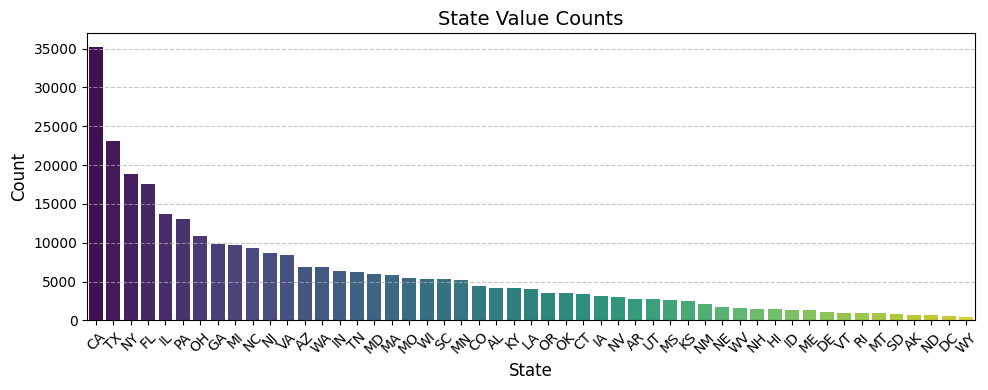

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the value counts
state_counts = df['state'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('State', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('State Value Counts', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [87]:
def group_states(df: pd.DataFrame, 
                state_column: str,          
                new_column_name: Optional[str] = 'state') -> pd.DataFrame:
    # Define refined groups based on distance and income
    state_groups = {
        'CA': ['CA'],                          # High count, high income
        'TX': ['TX'],                          # High count, moderate income
        'NY': ['NY'],                          # High count, high income
        'FL': ['FL'],                          # High count, moderate income
        'IL-OH': ['IL', 'OH'],                 # Midwest, similar income
        'PA-NJ': ['PA', 'NJ'],                 # Northeast, high income
        'GA-NC-SC': ['GA', 'NC', 'SC'],        # Southeast, moderate income
        'MI-IN-MN-WI': ['MI', 'IN', 'MN', 'WI'],  # Great Lakes, expanded
        'VA-MD': ['VA', 'MD'],                 # Mid-Atlantic, high income
        'WA-OR': ['WA', 'OR'],                 # Pacific NW, high income
        'AZ-NV-CO-UT': ['AZ', 'NV', 'CO', 'UT'],  # Southwest, expanded
        'TN-KY-AL-LA-MS-AR': ['TN', 'KY', 'AL', 'LA', 'MS', 'AR'],  # Southern, expanded
        'MO-IA-KS': ['MO', 'IA', 'KS'],        # Central Plains
        'New England High': ['MA', 'CT', 'NH'],  # High income, compact
        'Low-Volume Mixed': ['OK', 'NM', 'NE', 'WV', 'ME', 'ID', 'HI', 'DE', 'VT', 'SD', 'RI', 'MT', 'AK', 'ND', 'DC', 'WY']  # Reduced
    }
    # Create reverse mapping from state to group
    state_to_group = {
        state: group
        for group, states in state_groups.items()
        for state in states
    }
    
    # Create new column with grouped states
    df = df.copy()
    df[new_column_name] = df[state_column].map(state_to_group)
    
    return df

In [89]:
df = group_states(df, 'state')

##### <font color='blue'> plot state group distrebutaion

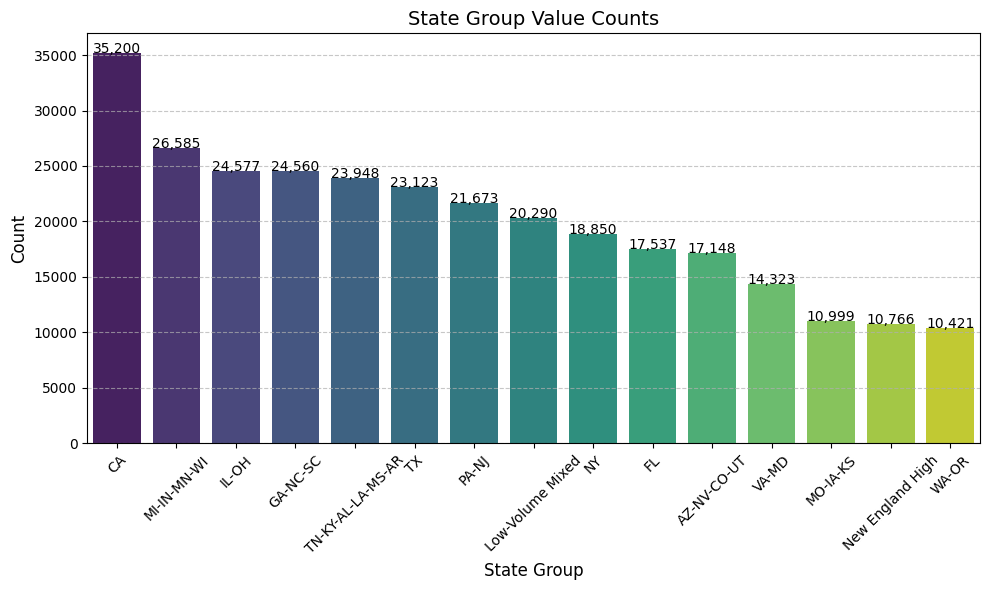

In [92]:
# Get the value counts of the 'state_group' column
state_group_counts = df['state'].value_counts()

# Create a bar plot of the state_group value counts
plt.figure(figsize=(10, 6))
sns.barplot(x=state_group_counts.index, y=state_group_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('State Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('State Group Value Counts', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars
for index, value in enumerate(state_group_counts.values):
    plt.text(index, value + 10, f"{value:,}", ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


#### <font color='Indigo'>create distance_km column as the distance between customer location and merchant location

In [95]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points 
    on Earth in kilometers using the Haversine formula.
    
    Parameters:
        lat1, lon1: latitude and longitude of first point (living)
        lat2, lon2: latitude and longitude of second point (merchant)
    
    Returns:
        Distance in kilometers (rounded to nearest integer)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # using the Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) # Using arctan2 here
    R = 6371.0
    return int(np.round(R * c))

# Example usage with a DataFrame
def calculate_distances(df):
    """
    Calculate distances for all rows in the DataFrame
    Assumes columns: lat, long, merch_lat, merch_long
    """
    # Apply the haversine_distance function row by row, passing individual scalar values
    df['distance_km'] = df.apply(
        lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
        axis=1
    )
    return df

In [97]:
df_tmp = calculate_distances(df)
# Use pd.cut() to group 'distance_km' into 10 equal-width bins and label them directly
labels = ["Very Close", "Close", "Somewhat Close", "Moderate", "Intermediate", 
          "Far", "Very Far", "Extremely Far", "Distant", "Very Distant"]

df['distance_category'] = pd.cut(df_tmp['distance_km'], bins=10, labels=labels)

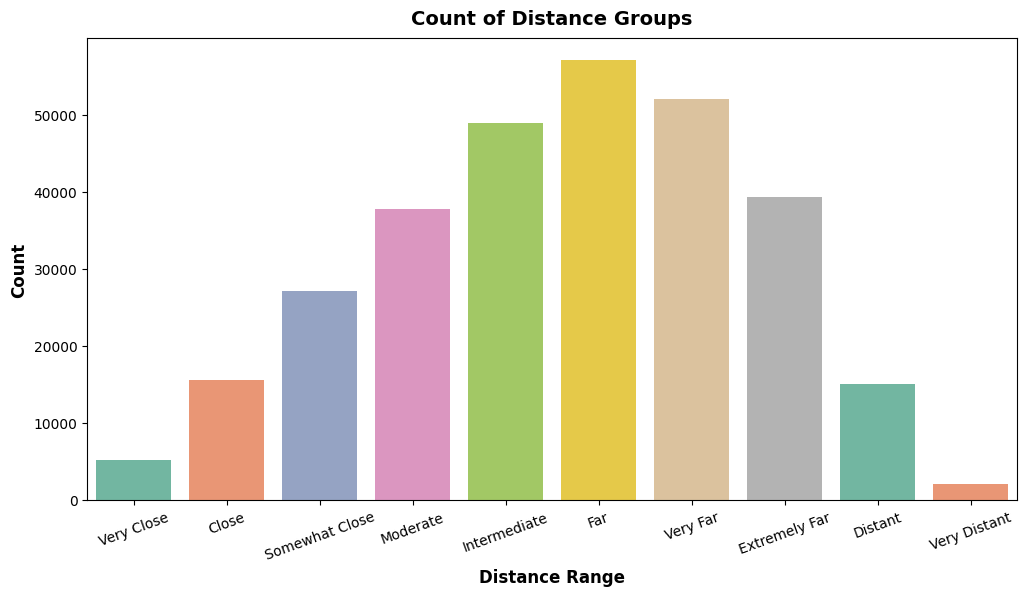

In [98]:
palette_colors = sns.color_palette("Set2", len(labels))  

# Create a countplot with colors
plt.figure(figsize=(12, 6))
sns.countplot(x='distance_category', data=df, order=labels, palette=palette_colors)

# Improve plot aesthetics
plt.title('Count of Distance Groups', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Distance Range', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=20)  # Rotate labels if needed

# Show the plot
plt.show()

#### <font color='Indigo'>group city population 

In [102]:
city_pop_min = df['city_pop'].min()
city_pop_max = df['city_pop'].max()

print(f"City Population Range: {city_pop_min} - {city_pop_max}")
print(df['city_pop'].nunique())

City Population Range: 44 - 2906700
5879


In [104]:
labels = [
    "Very Small Town", "Small Town", "Midsize Town", "Large Town",
    "Small City", "Midsize City", "Large City", "Major City",
    "Metropolitan Area", "Large Metropolitan Area"
]

df['city_pop_range'] = pd.qcut(df['city_pop'], q=10, labels=labels)

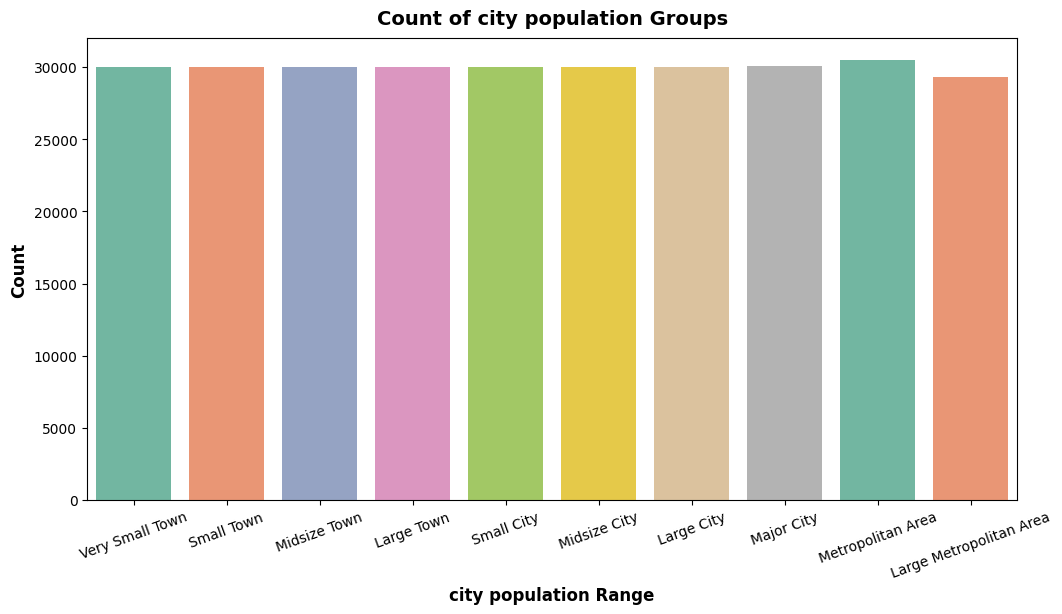

In [106]:
palette_colors = sns.color_palette("Set2", len(labels))  

# Create a countplot with colors
plt.figure(figsize=(12, 6))
sns.countplot(x='city_pop_range', data=df, order=labels, palette=palette_colors)

# Improve plot aesthetics
plt.title('Count of city population Groups', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('city population Range', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=20)  # Rotate labels if needed

# Show the plot
plt.show()

#### <font color='Indigo'>group jobs

In [109]:
df['job'].nunique()

639

In [111]:
def group_jobs(df: pd.DataFrame, 
                job_column: str,          
                new_column_name: Optional[str] = 'job') -> pd.DataFrame:
    # Define 15 groups optimized for credit card fraud detection
    job_groups = {
        "Finance & Banking Professionals": ['Accountant, chartered', 'Financial adviser', 'Corporate investment banker', 'Tax inspector', 'Financial controller', 'Chief Financial Officer', 'Corporate treasurer', 'Insurance underwriter', 'Financial trader', 'Bonds trader', 'Operational investment banker', 'Financial risk analyst', 'Tax adviser', 'Accounting technician', 'Banker', 'Investment banker, corporate', 'Financial planner', 'Actuary', 'Chartered certified accountant', 'Accountant, chartered public finance', 'Investment banker, operational', 'Financial manager', 'Chartered management accountant', 'Chartered public finance accountant', 'Retail banker', 'Futures trader', 'Accountant, chartered management', 'Insurance account manager', 'Risk analyst', 'Chartered accountant', 'Investment analyst', 'Insurance broker', 'Insurance claims handler', 'Loss adjuster, chartered', 'Pensions consultant', 'Equities trader', 'Economist', 'Comptroller', 'Senior tax professional/tax inspector', 'Accountant, chartered certified'],
        "Executive & Senior Management": ['Chief Executive Officer', 'Chief Operating Officer', 'Hotel manager', 'Chief Strategy Officer', 'Production manager', 'Call centre manager', 'Health service manager', 'Chief of Staff', 'Fitness centre manager', 'Restaurant manager', 'Office manager', 'Theatre manager', 'Conference centre manager', 'Product manager', 'Chief Technology Officer', 'Chief Marketing Officer', 'Facilities manager', 'Housing manager/officer', 'Leisure centre manager', 'Theme park manager', 'Public house manager', 'Quality manager', 'Risk manager', 'Management consultant', 'Energy manager', 'Customer service manager', 'Manufacturing systems engineer', 'Engineer, manufacturing systems', 'Administrator', 'Administrator, Civil Service', 'Administrator, local government'],
        "IT & Technology Specialists": ['Computer games developer', 'Systems developer', 'Database administrator', 'IT consultant', 'Software engineer', 'Multimedia programmer', 'Applications developer', 'Network engineer', 'Games developer', 'Web designer', 'IT trainer', 'Data scientist', 'Programmer, systems', 'Programmer, applications', 'IT technical support officer', 'Systems analyst', 'Programmer, multimedia', 'Data processing manager', 'Information systems manager', 'IT sales professional', 'Engineer, maintenance (IT)', 'Engineer, broadcasting (operations)', 'Telecommunications researcher', 'Technical author', 'Intelligence analyst', 'Geographical information systems officer', 'Product/process development scientist'],
        "Medical & Healthcare Specialists": ['Dispensing optician', 'Doctor, hospital', 'Surgeon', 'Psychiatrist', 'Neurosurgeon', 'Biomedical scientist', 'Ambulance person', 'Paediatric nurse', 'Nurse, adult', 'Hospital doctor', 'General practice doctor', 'Dentist', 'Optometrist', 'Physiotherapist', 'Occupational therapist', 'Pharmacist, hospital', 'Pharmacist, community', 'Community pharmacist', 'Diagnostic radiographer', 'Pathologist', 'Haematologist', 'Ophthalmologist', 'Medical physicist', 'Clinical research associate', 'Clinical psychologist', 'Biomedical engineer', 'Clinical scientist, histocompatibility and immunogenetics', 'Biochemist, clinical', 'Clinical molecular geneticist', 'Mental health nurse', 'Oncologist', 'Hospital pharmacist', 'Immunologist', 'Midwife', 'Dietitian', 'Nurse, mental health', 'Cytogeneticist', 'Clinical cytogeneticist', 'Clinical embryologist', 'Nurse, learning disability', 'Nurse, children\'s', 'Speech and language therapist', 'Therapist, speech and language', 'Engineer, biomedical', 'Radiographer, therapeutic', 'Acupuncturist', 'Osteopath', 'Sports therapist', 'Nutritional therapist', 'Therapist, nutritional', 'Health promotion specialist', 'Health physicist', 'Physiological scientist', 'Therapeutic radiographer', 'Chiropractor', 'Chiropodist', 'Psychiatric nurse', 'Veterinary surgeon', 'Medical illustrator', 'Exercise physiologist', 'Pharmacologist', 'Therapist, occupational', 'Orthoptist', 'Podiatrist', 'Optician, dispensing', 'Radiographer, diagnostic', 'Medical laboratory scientific officer', 'Adult nurse', 'Therapist, sports', 'Embryologist, clinical', 'Learning disability nurse', 'Physicist, medical', 'Paramedic', 'Medical technical officer', 'Research scientist (medical)', 'Scientist, audiological', 'Clinical biochemist', 'Audiological scientist', 'Doctor, general practice'],
        "Sales & Marketing Professionals": ['Marketing executive', 'Sales executive', 'Retail buyer', 'Advertising account executive', 'Media buyer', 'Buyer, retail', 'Market researcher', 'Sales promotion account executive', 'Purchasing manager', 'Retail manager', 'Industrial buyer', 'Advertising account planner', 'Public relations account executive', 'Sales professional, IT', 'Retail merchandiser', 'Advertising art director', 'Buyer, industrial', 'Visual merchandiser', 'Trading standards officer', 'Media planner', 'Advertising copywriter', 'Public relations officer', 'Editorial assistant', 'Merchandiser, retail', 'Medical sales representative', 'Publishing rights manager', 'Print production planner', 'Recruitment consultant', 'Advertising copywriter', 'Copywriter, advertising', 'Press sub'],
        "Engineering & Technical Experts": ['Engineer, civil (consulting)', 'Chemical engineer', 'Mechanical engineer', 'Engineer, communications', 'Technical sales engineer', 'Engineer, manufacturing', 'Engineer, control and instrumentation', 'Engineer, drilling', 'Energy engineer', 'Site engineer', 'Engineer, maintenance', 'Electrical engineer', 'Engineer, production', 'Engineer, materials', 'Communications engineer', 'Engineer, automotive', 'Civil engineer, contracting', 'Engineer, chemical', 'Engineer, aeronautical', 'Engineer, petroleum', 'Engineer, structural', 'Engineer, electrical', 'Engineer, electronics', 'Engineer, energy', 'Production engineer', 'Water engineer', 'Engineer, water', 'Consulting civil engineer', 'Manufacturing systems engineer', 'Engineer, mining', 'Structural engineer', 'Contracting civil engineer', 'Drilling engineer', 'Engineer, building services', 'Electronics engineer', 'Civil engineer, consulting', 'Automotive engineer', 'Engineer, site', 'Mining engineer', 'Engineer, civil (contracting)', 'Control and instrumentation engineer', 'Aeronautical engineer', 'Petroleum engineer', 'Engineer, technical sales', 'Engineer, agricultural', 'Engineering geologist', 'Naval architect', 'Ergonomist', 'Building services engineer', 'Maintenance engineer', 'Contractor', 'Materials engineer', 'Quarry manager', 'Architect', 'Broadcast engineer', 'Manufacturing engineer', 'Engineer, land', 'Building control surveyor'],
        "Legal & Policy Professionals": ['Barrister', 'Solicitor', 'Lobbyist', 'Public affairs consultant', 'Patent attorney', 'Chartered legal executive (England and Wales)', 'Legal executive', 'Trade mark attorney', 'Lawyer', 'Legal secretary', 'Probation officer', 'Regulatory affairs officer', 'Company secretary', 'Licensed conveyancer', 'Solicitor, Scotland', 'Barrister\'s clerk', 'Local government officer', 'Civil Service fast streamer', 'Government social research officer', 'Politician\'s assistant', 'Diplomatic Services operational officer', 'Equality and diversity officer', 'Civil Service administrator', 'Immigration officer', 'Police officer', 'Social research officer, government', 'Emergency planning/management officer', 'Prison officer', 'Race relations officer', 'Secretary/administrator', 'Secretary, company', 'Administrator, education', 'Personnel officer', 'Patent examiner'],
        "Media & Creative Professionals": ['Editor, commissioning', 'Administrator, arts', 'Broadcast presenter', 'Television/film/video producer', 'Graphic designer', 'Photographer', 'Musician', 'Camera operator', 'Presenter, broadcasting', 'Editor, film/video', 'Fashion designer', 'Designer, industrial/product', 'Theatre stage manager', 'Art gallery manager', 'Designer, multimedia', 'Multimedia specialist', 'Television camera operator', 'Broadcast journalist', 'Magazine journalist', 'Designer, interior/spatial', 'Designer, fashion/clothing', 'Designer, furniture', 'Designer, exhibition/display', 'Designer, textile', 'Film/video editor', 'Producer, television/film/video', 'Stage manager', 'Artist', 'Radio producer', 'Production assistant, radio', 'Video editor', 'Designer, television/film set', 'Journalist, newspaper', 'Production assistant, television', 'Journalist, magazine', 'Journalist, broadcasting', 'Commercial art gallery manager', 'Newspaper journalist', 'Press photographer', 'Animator', 'Theatre director', 'Producer, radio', 'Copy', 'Production designer, theatre/television/film', 'Runner, broadcasting/film/video', 'Television floor manager', 'Music tutor', 'Set designer', 'Arts administrator', 'Special effects artist', 'Sound technician, broadcasting/film/video', 'Gaffer', 'Best boy', 'Exhibition designer', 'Location manager', 'Television production assistant', 'Programme researcher, broadcasting/film/video', 'Publishing copy', 'Designer, graphic', 'Magazine features editor', 'Product designer', 'Editor, magazine features', 'Writer', 'Radio broadcast assistant', 'Lighting technician, broadcasting/film/video', 'Commissioning editor', 'Editor, commissionin'],
        "Education & Research Professionals": ['Teacher, primary school', 'Professor Emeritus', 'Research scientist (life sciences)', 'Higher education lecturer', 'Educational psychologist', 'Education officer, museum', 'Teacher, special educational needs', 'Education administrator', 'Research scientist (physical sciences)', 'Scientist, research (maths)', 'Scientist, research (medical)', 'Academic librarian', 'Further education lecturer', 'Careers adviser', 'Special educational needs teacher', 'Teacher, secondary school', 'Lecturer, higher education', 'Teacher, adult education', 'Education officer, community', 'Museum education officer', 'Research officer, government', 'Research officer, political party', 'Associate Professor', 'Learning mentor', 'English as a second language teacher', 'Teacher, English as a foreign language', 'Community education officer', 'Early years teacher', 'Journalist, newspaper', 'Higher education careers adviser', 'Lecturer, further education', 'Teacher, music', 'Social researcher', 'Primary school teacher', 'Secondary school teacher', 'Curator', 'Librarian, academic', 'Museum/gallery exhibitions officer', 'Librarian, public', 'Public librarian', 'Careers information officer', 'Training and development officer', 'Private music teacher', 'TEFL teacher', 'English as a foreign language teacher', 'Armed forces training and education officer', 'Teacher, early years/pre', 'Teaching laboratory technician', 'Museum/gallery curator'],
        "Hospitality & Tourism Workers": ['Catering manager', 'Hotel manager', 'Tour manager', 'Restaurant manager', 'Travel agency manager', 'Accommodation manager', 'Restaurant manager, fast food', 'Event organiser', 'Tourism officer', 'Fast food restaurant manager', 'Public house manager', 'Conference centre manager', 'Theme park manager', 'Holiday representative', 'Tourist information centre manager', 'Outdoor activities/education manager', 'Food technologist', 'Barista', 'Brewing technologist', 'Fitness centre manager', 'Leisure centre manager', 'Cabin crew', 'Air cabin crew', 'Air broker'],
        "Psychology & Social Service Workers": ['Psychologist, clinical', 'Social worker', 'Counselling psychologist', 'Community development worker', 'Psychologist, educational', 'Psychologist, sport and exercise', 'Forensic psychologist', 'Occupational psychologist', 'Psychologist, counselling', 'Therapist, drama', 'Therapist, music', 'Psychotherapist', 'Child psychotherapist', 'Psychologist, occupational', 'Psychologist, forensic', 'Sport and exercise psychologist', 'Psychotherapist, child', 'Dance movement psychotherapist', 'Youth worker', 'Advice worker', 'Aid worker', 'Development worker, community', 'Development worker, international aid', 'Volunteer coordinator', 'Art therapist', 'Music therapist', 'Charity fundraiser', 'International aid/development worker', 'Arts development officer', 'Community arts worker', 'Therapist, horticultural', 'Dramatherapist', 'Sports coach', 'Psychologist, prison and probation services', 'Health visitor', 'Counsellor', 'Adult guidance worker', 'Sports development officer', 'Sports administrator', 'Charity officer', 'Psychotherapist, dance movement', 'Therapist, art'],
        "Transportation & Logistics Workers": ['Airline pilot', 'Merchant navy officer', 'Logistics and distribution manager', 'Transport planner', 'Passenger transport manager', 'Warehouse manager', 'Pilot, airline', 'Ship broker', 'Freight forwarder', 'Air traffic controller', 'Fisheries officer', 'Armed forces logistics/support/administrative officer', 'Claims inspector/assessor', 'Surveyor, hydrographic', 'Surveyor, planning and development', 'Surveyor, quantity', 'Surveyor, land/geomatics', 'Surveyor, building', 'Surveyor, commercial/residential', 'Surveyor, mining', 'Surveyor, minerals', 'Surveyor, building control', 'Surveyor, insurance', 'Quantity surveyor', 'Building surveyor', 'Commercial/residential surveyor', 'Land/geomatics surveyor', 'Armed forces technical officer', 'Armed forces operational officer', 'Minerals surveyor', 'Planning and development surveyor', 'Town planner', 'Hydrographic surveyor', 'Land', 'Building control surveyor'],
        "Science & Environmental Specialists": ['Chemist, analytical', 'Geoscientist', 'Environmental consultant', 'Scientist, marine', 'Hydrologist', 'Scientific laboratory technician', 'Animal nutritionist', 'Geochemist', 'Microbiologist', 'Soil scientist', 'Water quality scientist', 'Meteorologist', 'Agricultural consultant', 'Ecologist', 'Environmental manager', 'Hydrogeologist', 'Oceanographer', 'Scientist, biomedical', 'Scientist, physiological', 'Scientist, water quality', 'Environmental education officer', 'Geologist, engineering', 'Geophysicist/field seismologist', 'Field trials officer', 'Scientist, clinical (histocompatibility and immunogenetics)', 'Operations geologist', 'Forensic scientist', 'Marine scientist', 'Scientist, research (physical sciences)', 'Archaeologist', 'Operational researcher', 'Product/process development scientist', 'Research scientist (maths)', 'Environmental health practitioner', 'Waste management officer', 'Nature conservation officer', 'Scientist, research (life sciences)', 'Mudlogger', 'Geologist, wellsite', 'Wellsite geologist', 'Analytical chemist', 'Toxicologist', 'Geophysical data processor', 'Physiological scientist', 'Astronomer', 'Radiation protection practitioner', 'Environmental education officer', 'Recycling officer', 'Science writer', 'Herpetologist', 'Health and safety inspector', 'Education officer, environmental', 'Animal technologist', 'Metallurgist', 'Geneticist, molecular', 'Scientist, forensic', 'Health and safety adviser', 'Seismic interpreter', 'Scientist, product/process development'],
        "Agriculture & Horticulture Workers": ['Agricultural consultant', 'Farm manager', 'Horticulturist, amenity', 'Soil scientist', 'Tree surgeon', 'Animal nutritionist', 'Horticulturist, commercial', 'Arboriculturist', 'Agricultural engineer', 'Amenity horticulturist', 'Horticultural consultant', 'Fish farm manager', 'Forest/woodland manager', 'Warden/ranger', 'Conservation officer, nature', 'Plant breeder/geneticist', 'Horticultural therapist', 'Commercial horticulturist', 'Landscape architect', 'Rural practice surveyor', 'Surveyor, rural practice', 'Field seismologist', 'Environmental scientist', 'Ranger/warden', 'Estate manager/land agent'],
        "Miscellaneous & Low-Transaction Trades": ['Firefighter', 'Designer, jewellery', 'Bookseller', 'Glass blower/designer', 'Actor', 'Musician', 'Dancer', 'Printmaker', 'Ceramics designer', 'Furniture designer', 'Jewellery designer', 'Designer, blown glass/stained glass', 'Designer, ceramics/pottery', 'Fine artist', 'Illustrator', 'Cartographer', 'Translator', 'Interpreter', 'Proofreader', 'Archivist', 'Conservation officer, historic buildings', 'Heritage manager', 'Historic buildings inspector/conservation officer', 'Conservator, furniture', 'Conservator, museum/gallery', 'Barista', 'Human resources officer', 'Trade union research officer', 'Information officer', 'Exhibitions officer, museum/gallery', 'Dealer', 'Acupuncturist', 'Homeopath', 'Estate agent', 'Occupational hygienist', 'Technical brewer', 'Make', 'Health and safety inspector', 'Administrator, charities/voluntary organisations', 'Records manager', 'Personal assistant', 'Insurance risk surveyor', 'Phytotherapist', 'Statistician', 'Lexicographer', 'Pension scheme manager', 'Sub', 'Chartered loss adjuster', 'Museum/gallery conservator', 'Furniture conservator/restorer', 'Colour technologist', 'Clothing/textile technologist', 'Garment/textile technologist', 'Industrial/product designer', 'Interior and spatial designer', 'Textile designer', 'Architectural technologist', 'Podiatrist', 'Osteopath', 'Herbalist', 'Veterinary surgeon', 'Chiropodist', 'Chiropractor', 'Charity officer', 'Research officer, trade union', 'Administrator, sports', 'Medical secretary']
    }
    # Create reverse mapping from job to group
    job_to_group = {
        job: group
        for group, jobs in job_groups.items()
        for job in jobs
    }
    
    # Create new column with grouped states
    df = df.copy()
    df[new_column_name] = df[job_column].map(job_to_group)
    
    return df

In [113]:
df = group_jobs(df, 'job')

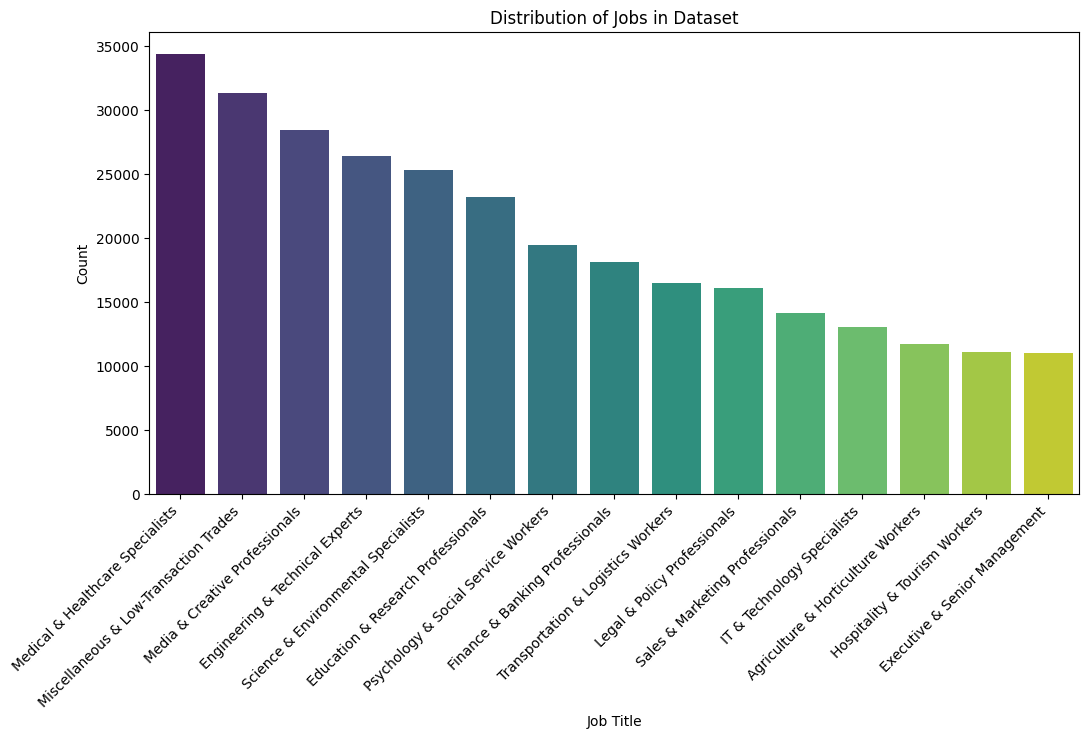

In [115]:
# Count unique job values
job_counts = df['job'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=job_counts.index, y=job_counts.values, palette="viridis")

# Labels and title
plt.xticks(rotation=45, ha='right')  # Rotate job names for readability
plt.xlabel("Job Title")
plt.ylabel("Count")
plt.title("Distribution of Jobs in Dataset")

# Show plot
plt.show()

####  <font color='Indigo'> get customer age from dob

In [118]:
df['age'] = ((df['trans_date'] - df['dob']).dt.days / 365).round().astype(int)

In [120]:
#drop dob
df = df.drop(columns=['dob'])

In [122]:
df['age'].agg(['min', 'max'])

min    11
max    93
Name: age, dtype: int64

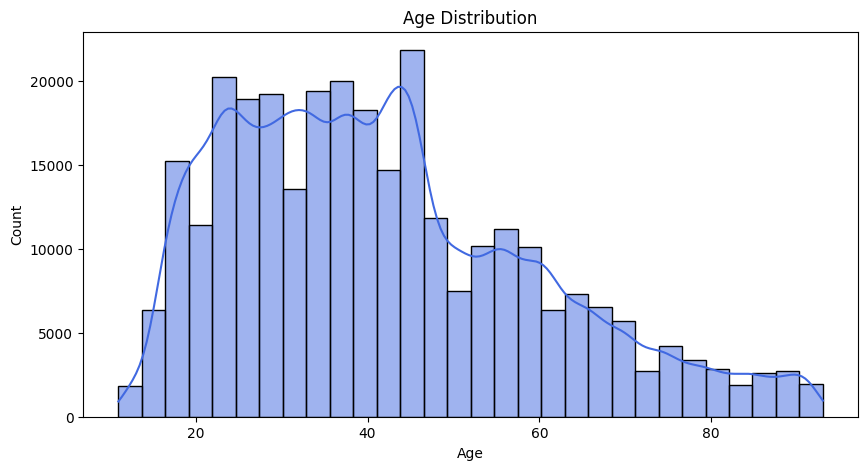

In [124]:
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=30, kde=True, color="royalblue")  # Histogram with density curve

# Labels and title
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")

# Show plot
plt.show()

In [125]:
# Categorize the ages into bins with labels
df['age_range'] = pd.cut(df['age'],bins=[0, 18, 22, 35, 50, 65, float('inf')], labels=['Teen', 'Student', 'Young Adult', 'Midlife', 'Mature Adult', 'Senior'], right=False)

In [126]:
# Aggregate the age groups
age_group_aggregation = df.groupby('age_range').size().reset_index(name='count')

age_group_aggregation

,age_range,count
0,Teen,12691
1,Student,22123
2,Young Adult,85534
3,Midlife,92407
4,Mature Adult,50275
5,Senior,36970


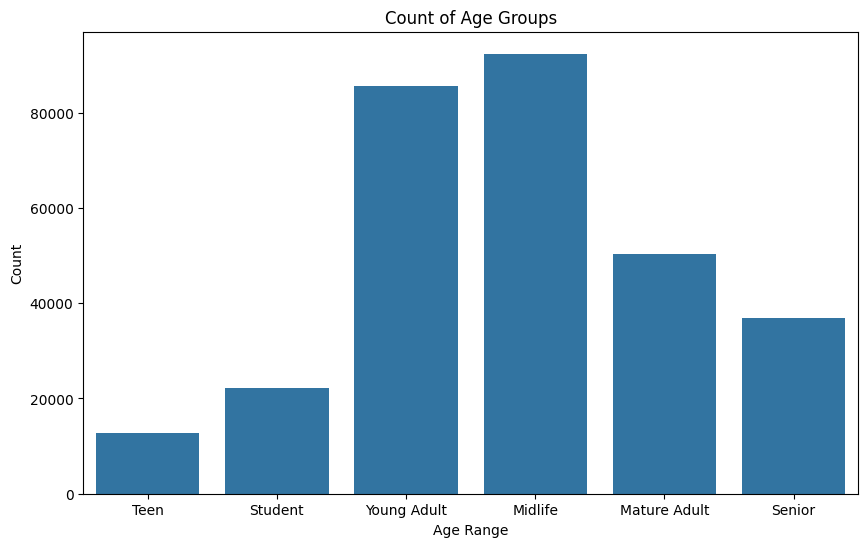

In [130]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='age_range', data=df, order=['Teen', 'Student', 'Young Adult', 'Midlife', 'Mature Adult', 'Senior'])
plt.title('Count of Age Groups')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

####  <font color='Indigo'>Clean and group profile names

In [133]:
df['profile'].value_counts()

profile
adults_2550_female_urban.json     84092
adults_2550_male_urban.json       75308
adults_50up_female_urban.json     47234
adults_50up_male_urban.json       44093
young_adults_male_urban.json      17789
young_adults_female_urban.json    15539
adults_2550_female_rural.json      4083
adults_50up_female_rural.json      3515
adults_50up_male_rural.json        3413
adults_2550_male_rural.json        3148
young_adults_male_rural.json        920
young_adults_female_rural.json      866
Name: count, dtype: Int64

In [135]:
# Clean profile names: remove underscores and 'json'
df['profile'] = df['profile'].str.replace('_', ' ').str.replace('.json', '')

# Group the specific profiles into 'young_adults_rural'
df['profile'] = df['profile'].replace({'young adults male rural': 'young adults rural', 'young adults female rural': 'young adults rural'})

In [137]:
df['profile'].value_counts()

profile
adults 2550 female urban     84092
adults 2550 male urban       75308
adults 50up female urban     47234
adults 50up male urban       44093
young adults male urban      17789
young adults female urban    15539
adults 2550 female rural      4083
adults 50up female rural      3515
adults 50up male rural        3413
adults 2550 male rural        3148
young adults rural            1786
Name: count, dtype: Int64

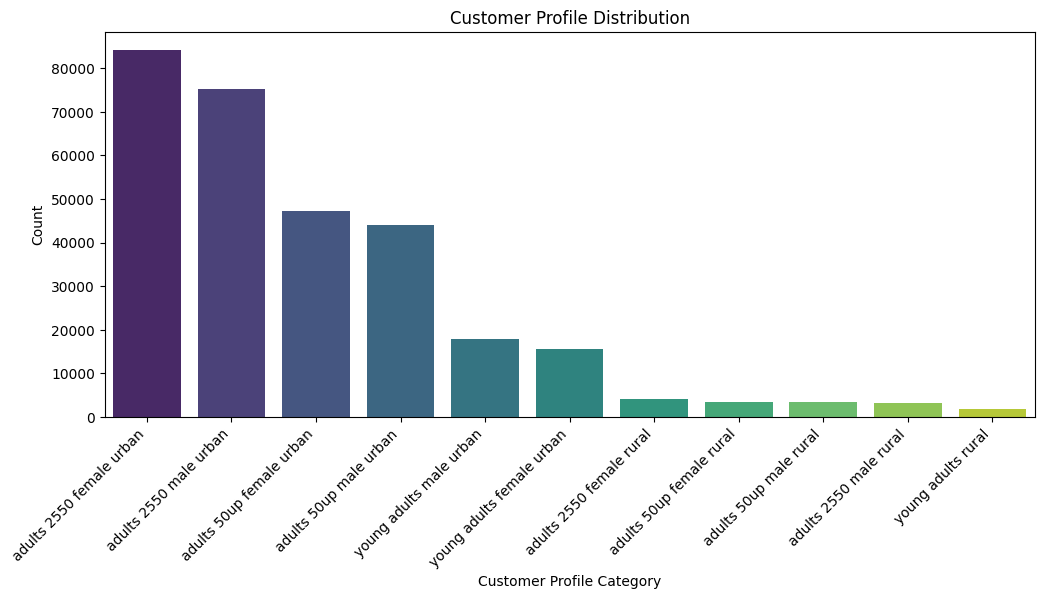

In [139]:
# Count unique profile categories
profile_counts = df['profile'].value_counts()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=profile_counts.index, y=profile_counts.values, palette="viridis")

# Labels and title
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.xlabel("Customer Profile Category")
plt.ylabel("Count")
plt.title("Customer Profile Distribution")

# Show plot
plt.show()

#### <font color='Indigo'> Extract trans_date Date-Based Features

In [142]:
df['trans_month'] = df['trans_date'].dt.month
df['trans_day'] = df['trans_date'].dt.day
df['is_weekend'] = (df['trans_date'].dt.weekday >= 5).astype(int)  # 1 if Sat/Sun, else 0

#drop trans_date
df = df.drop(columns=['trans_date'])

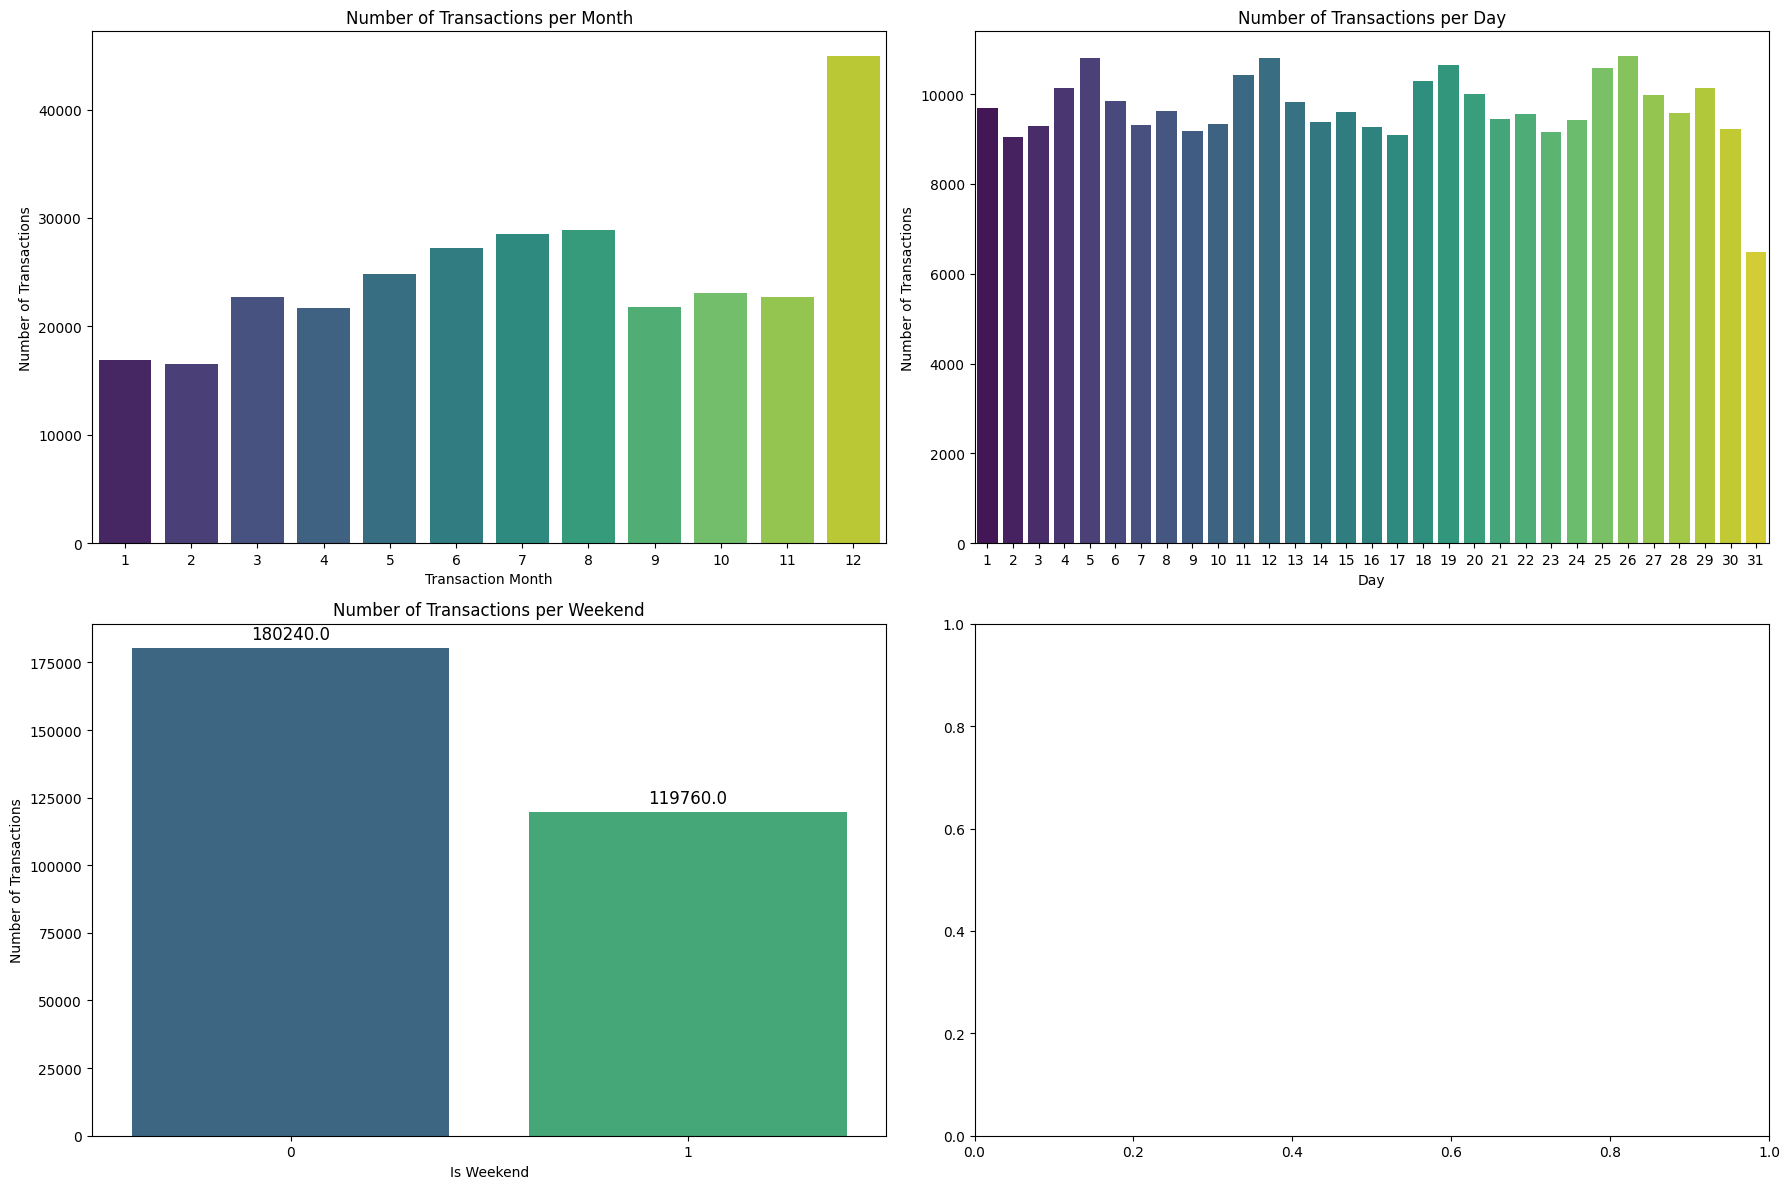

In [144]:
# Create a figure and set of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot number of transactions per month
sns.countplot(x='trans_month', data=df, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title('Number of Transactions per Month')
axes[0, 0].set_xlabel('Transaction Month')
axes[0, 0].set_ylabel('Number of Transactions')

# Plot number of transactions per weekday
sns.countplot(x='trans_day', data=df, palette="viridis", ax=axes[0, 1])
axes[0, 1].set_title('Number of Transactions per Day')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Number of Transactions')

# Plot number of transactions per weekend
sns.countplot(x='is_weekend', data=df, palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('Number of Transactions per Weekend')
axes[1, 0].set_xlabel('Is Weekend')
axes[1, 0].set_ylabel('Number of Transactions')
# Add the count labels on the bars
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                        textcoords='offset points')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

#### <font color='Indigo'>get hour of transaction from trans_time

In [146]:
df['trans_time'] = df['trans_time'].dt.hour

In [149]:
def get_time_group(hour: int) -> str:
    """Return the time group based on the hour of the day.

    Args:
        hour (int): Hour of the day, from 0 to 23.

    Returns:
        str: 'Night' for hours 22-3, 'Day' for hours 4-15, 'Evening' for hours 16-21.
    """
    if hour >= 22 or hour < 4:
        return 'Night'
    elif hour >= 4 and hour < 16:
        return 'Day'
    elif hour >= 16 and hour < 22:
        return 'Evening'

In [151]:
df['trans_time_group'] = df['trans_time'].apply(get_time_group)

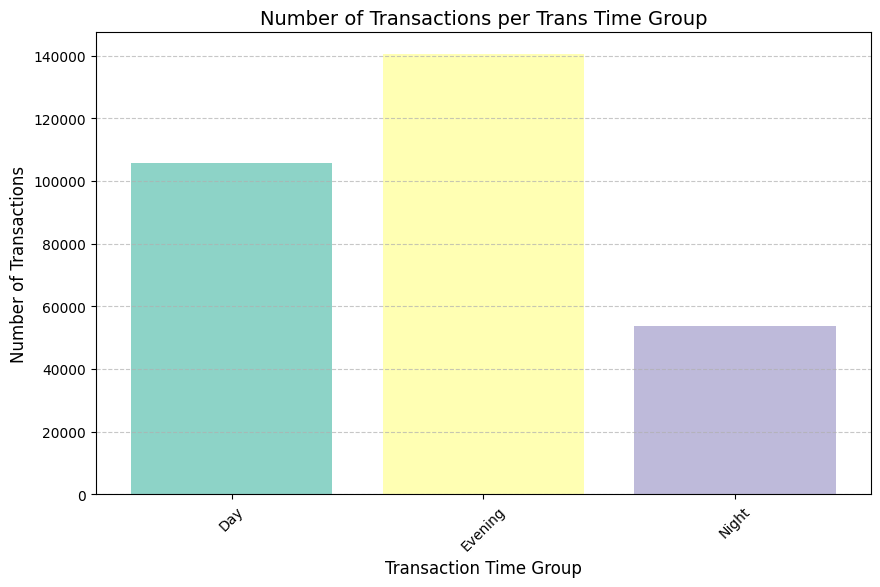

In [153]:
trans_counts = df['trans_time_group'].value_counts().sort_index()
colors = plt.cm.Set3(range(len(trans_counts)))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(trans_counts.index, trans_counts.values, color=colors)

plt.title('Number of Transactions per Trans Time Group', fontsize=14)
plt.xlabel('Transaction Time Group', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### <font color='Indigo'>drop unix_time

In [156]:
df = df.drop(columns=['unix_time'])

#### <font color='Indigo'>group 6 rare categories

In [159]:
df['category'].value_counts()

category
home              56378
kids_pets         52113
food_dining       45072
personal_care     42686
health_fitness    37442
entertainment     37182
travel            19312
shopping_pos       8612
grocery_pos         408
shopping_net        374
misc_net            192
gas_transport       149
misc_pos             50
grocery_net          30
Name: count, dtype: Int64

In [161]:
category_stats = (
    df.groupby('category')
      .agg(total_transactions=('category', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index().sort_values(by='total_transactions', ascending=True))

print(category_stats)

          category  total_transactions  total_fraud
3      grocery_net                  30           30
9         misc_pos                  50           50
2    gas_transport                 149          149
8         misc_net                 192          192
11    shopping_net                 374          374
4      grocery_pos                 408          408
12    shopping_pos                8612          171
13          travel               19312           20
0    entertainment               37182           44
5   health_fitness               37442           29
10   personal_care               42686           44
1      food_dining               45072           43
7        kids_pets               52113           38
6             home               56378           38


In [163]:
# Define the categories to group
small_categories = ['shopping_net', 'misc_net', 'gas_transport', 'misc_pos', 'grocery_net','grocery_pos']

# Replace small categories with "other"
df['category'] = df['category'].replace(small_categories, 'other')

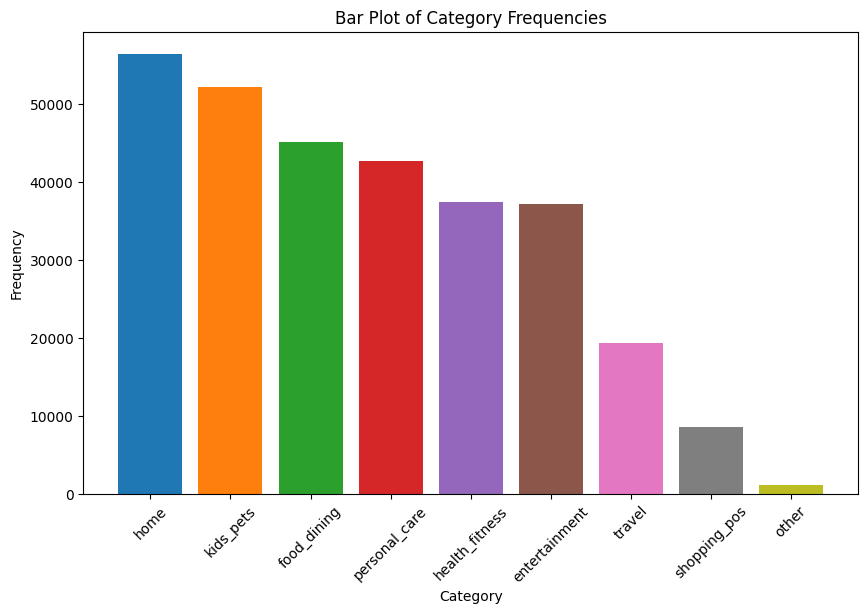

In [165]:
# Set the figure size for a wider plot
plt.figure(figsize=(10, 6))

# Calculate the frequency of each category in the 'category' column
category_counts = df['category'].value_counts()

# Create a list of colors using a colormap (e.g., 'tab10')
# 'tab10' provides up to 10 distinct colors; adjust based on your needs
colors = plt.cm.tab10(range(len(category_counts)))

# Create a bar plot with multiple colors
plt.bar([str(cat) for cat in category_counts.index], category_counts.values, color=colors)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Bar Plot of Category Frequencies')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

#### <font color='Indigo'>clean merchant text

In [168]:
df['merchant'].value_counts()

merchant
fraud_Schiller, Blanda and Johnson         1188
fraud_Prosacco, Kreiger and Kovacek        1186
fraud_Schmidt-Larkin                       1177
fraud_Wuckert-Goldner                      1173
fraud_Cole, Hills and Jewess               1172
                                           ... 
fraud_Swift, Bradtke and Marquardt            1
fraud_Spencer-Runolfsson                      1
fraud_Spinka-Welch                            1
fraud_Huels-Hahn                              1
fraud_Kerluke, Considine and Macejkovic       1
Name: count, Length: 636, dtype: Int64

In [170]:
df['merchant'] = df['merchant'].str.replace('fraud_', '').str.replace(',', '')

In [172]:
df['merchant'].value_counts()

merchant
Schiller Blanda and Johnson         1188
Prosacco Kreiger and Kovacek        1186
Schmidt-Larkin                      1177
Wuckert-Goldner                     1173
Cole Hills and Jewess               1172
                                    ... 
Swift Bradtke and Marquardt            1
Spencer-Runolfsson                     1
Spinka-Welch                           1
Huels-Hahn                             1
Kerluke Considine and Macejkovic       1
Name: count, Length: 636, dtype: Int64

In [174]:
category_stats = (
    df.groupby('merchant')
      .agg(total_transactions=('merchant', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index().sort_values(by='total_fraud', ascending=False))

print(category_stats)

                           merchant  total_transactions  total_fraud
514    Schmeler Bashirian and Price                  16           16
342        Labadie Treutel and Bode                  15           15
496        Ruecker Beer and Collier                  15           15
557                   Stracke-Lemke                  14           14
398                    Miller-Hauck                  13           13
..                              ...                 ...          ...
221         Hauck Dietrich and Funk                1034            0
220       Hartmann Rowe and Hermann                 392            0
478  Ritchie Bradtke and Stiedemann                 354            0
215                   Hammes-Beatty                1069            0
504                Satterfield-Lowe                 372            0

[636 rows x 3 columns]


#### <font color='Indigo'>fix types and remove unnecessary fields to side files

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ssn                300000 non-null  int32   
 1   cc_num             300000 non-null  int64   
 2   gender             300000 non-null  int32   
 3   city               300000 non-null  string  
 4   state              300000 non-null  object  
 5   zip                300000 non-null  int64   
 6   lat                300000 non-null  float64 
 7   long               300000 non-null  float64 
 8   city_pop           300000 non-null  int64   
 9   job                300000 non-null  object  
 10  acct_num           300000 non-null  int64   
 11  profile            300000 non-null  string  
 12  trans_num          300000 non-null  string  
 13  trans_time         300000 non-null  int32   
 14  category           300000 non-null  string  
 15  amt                300000 non-null

In [179]:
df['cc_num'] = df['cc_num'].astype('int64')
df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   ssn                300000 non-null  int32   
 1   cc_num             300000 non-null  int64   
 2   gender             300000 non-null  int32   
 3   city               300000 non-null  string  
 4   state              300000 non-null  string  
 5   zip                300000 non-null  int64   
 6   lat                300000 non-null  float64 
 7   long               300000 non-null  float64 
 8   city_pop           300000 non-null  int64   
 9   job                300000 non-null  string  
 10  acct_num           300000 non-null  int64   
 11  profile            300000 non-null  string  
 12  trans_num          300000 non-null  string  
 13  trans_time         300000 non-null  int32   
 14  category           300000 non-null  string  
 15  amt                300000 non-null

In [181]:
# Split the data
df_extra = df[['trans_num', 'lat', 'long', 'merch_lat', 'merch_long']].copy()  # Extra data to be saved separately
df_main = df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'])  # Data for modeling

## Pickle file

In [184]:
# Save both as pickle files
df_extra.to_pickle(r'C:\Course\Repo\Files\Fraud detection\df_extra_features_after_data_prep_8.3.25.pkl')
df_main.to_pickle(r'C:\Course\Repo\Files\Fraud detection\df_model_data_after_data_prep_8.3.25.pkl')